In [107]:
import fastf1 as ff1
import fastf1.plotting
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd
import re

In [2]:
ff1.Cache.enable_cache('../cache')
plotting.setup_mpl()

In [3]:
year, event, event_type = 2023, 'Australia', 'R'
session = ff1.get_session(year, event, event_type)
laps = session.load_laps(with_telemetry=True)

C:\Users\Ricky\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1220: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
C:\Users\Ricky\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:1415: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, result], sort=False)

In [67]:
driver_1, driver_2, driver_3 = 'VER', 'HAM', 'ALO'

In [123]:
laps_driver_1 = laps.pick_driver(driver_1)
laps_driver_2 = laps.pick_driver(driver_2)
laps_driver_3 = laps.pick_driver(driver_3)

fastest_driver_1 = laps_driver_1.pick_fastest().get_telemetry().add_distance()
fastest_driver_2 = laps_driver_2.pick_fastest().get_telemetry().add_distance()
fastest_driver_3 = laps_driver_3.pick_fastest().get_telemetry().add_distance()

fastest_driver_1['Driver'] = driver_1
fastest_driver_2['Driver'] = driver_2
fastest_driver_3['Driver'] = driver_3

team_1 = laps_driver_1.pick_fastest()
team_2 = laps_driver_2.pick_fastest()
team_3 = laps_driver_3.pick_fastest()

team_color_1 = ff1.plotting.team_color(str(team_1['Team']))
team_color_2 = ff1.plotting.team_color(str(team_2['Team']))
team_color_3 = ff1.plotting.team_color(str(team_3['Team']))

team_colors = [team_color_1, team_color_2, team_color_3]

telemetry = fastest_driver_1.append(fastest_driver_2).append(fastest_driver_3)

C:\Users\Ricky\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:378: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_slice.loc[:, 'Time'] = data_slice['SessionTime'] - start_time
C:\Users\Ricky\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:378: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_slice.loc[:, 'Time'] = data_slice['SessionTime'] - start_time
C:\Users\Ricky\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastf1\core.py:378: FutureWarning: In a future version, `df.iloc[:, i] 

In [125]:
num_minisectors = 25
total_distance = total_distance = max(telemetry['Distance'])
minisector_length = total_distance / num_minisectors

In [126]:
minisectors = [0]

for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

In [127]:
telemetry['Minisector'] = telemetry['Distance'].apply(
    lambda dist: (
        int((dist // minisector_length) + 1)
    )
)

In [128]:
average_speed = telemetry.groupby(['Minisector', 'Driver'])['Speed'].mean().reset_index()

In [129]:
# Select the driver with the highest average speed
fastest_driver = average_speed.loc[average_speed.groupby(['Minisector'])['Speed'].idxmax()]

# Get rid of the speed column and rename the driver column
fastest_driver = fastest_driver[['Minisector', 'Driver']].rename(columns={'Driver': 'Fastest_driver'})

In [130]:
telemetry = telemetry.merge(fastest_driver, on=['Minisector'])
telemetry = telemetry.sort_values(by=['Distance'])
telemetry.loc[telemetry['Fastest_driver'] == driver_1, 'Fastest_driver_int'] = 1
telemetry.loc[telemetry['Fastest_driver'] == driver_2, 'Fastest_driver_int'] = 2
telemetry.loc[telemetry['Fastest_driver'] == driver_3, 'Fastest_driver_int'] = 3

In [131]:
# Calculate the number of minisectors dominated by each driver
minisectors_dominated_driver_1 = len(telemetry.loc[telemetry['Fastest_driver'] == driver_1, 'Minisector'].unique())
minisectors_dominated_driver_2 = len(telemetry.loc[telemetry['Fastest_driver'] == driver_2, 'Minisector'].unique())
minisectors_dominated_driver_3 = len(telemetry.loc[telemetry['Fastest_driver'] == driver_3, 'Minisector'].unique())

# Calculate the percentage of the track dominated by each driver
track_dominated_percentage_driver_1 = (minisectors_dominated_driver_1 / num_minisectors) * 100
track_dominated_percentage_driver_2 = (minisectors_dominated_driver_2 / num_minisectors) * 100
track_dominated_percentage_driver_3 = (minisectors_dominated_driver_3 / num_minisectors) * 100

In [132]:
plot_size = [18, 10]
plot_title = f"{session.event.year} {session.event.EventName} \n {driver_1} dominated: {track_dominated_percentage_driver_1: .2f}% \n {driver_2} dominated: {track_dominated_percentage_driver_2: .2f}% \n {driver_3} dominated: {track_dominated_percentage_driver_3: .2f}%"
plot_file = f"{session.event.year} {session.event.EventName}-{driver_1} VS {driver_2}-TrackDomination"
plot_filename = re.sub(r'\W+', '', plot_file.replace("\n", " ")) + ".png"

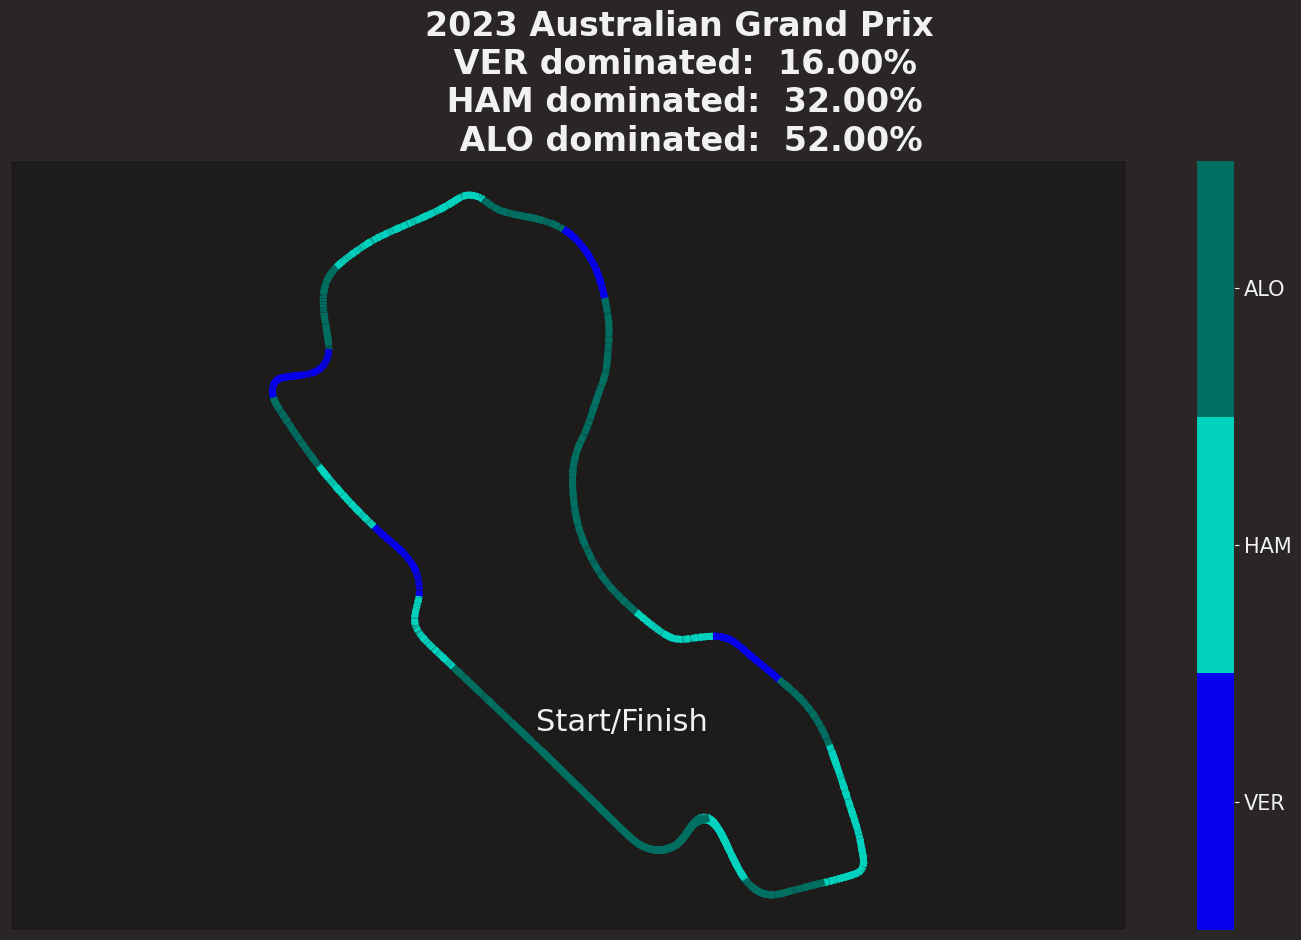

In [133]:
x = np.array(telemetry['X'].values)
y = np.array(telemetry['Y'].values)

plt.suptitle(plot_title, fontsize=24, fontweight='bold', y=1.03)

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
fastest_driver_array = telemetry['Fastest_driver_int'].to_numpy().astype(float)

# Find the y-coordinate of the starting point
start_y = segments[0][0][1]

# Calculate the width of the track
track_width = 9

# Set the start/finish line width to half of the track width
line_width = track_width / 2

# Draw the start/finish line
xmin = segments[0][0][0]
xmax = xmin + line_width
plt.hlines(y=start_y, xmin=xmin, xmax=xmax, color='red', linestyle='--', linewidth=2)

# Add the "Start/Finish" text
text_x = xmax + 600
text_y = start_y
plt.text(text_x, text_y, 'Start/Finish', fontsize=22, verticalalignment='center')

cmap = mcolors.ListedColormap(team_colors)
lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
lc_comp.set_array(fastest_driver_array)
lc_comp.set_linewidth(5)

plt.rcParams['figure.figsize'] = plot_size

plt.gca().add_collection(lc_comp)
plt.axis('equal')
plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1,5))
cbar.set_ticks([1.5, 2.5, 3.5])
cbar.set_ticklabels([driver_1, driver_2, driver_3])
cbar.ax.tick_params(labelsize=15)

plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
plt.show()